In [ ]:
# ----------------------------------------------------------------------
# 1. SETUP AND MOUNT GOOGLE DRIVE
# ----------------------------------------------------------------------
import os
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
print("Google Drive mounted successfully. ✅")

# Define the paths based on your structure: /content/drive/My Drive/Spoof_data/{train, test}/{live, spoof}/img.png
BASE_PATH = '/content/drive/My Drive/Spoof_data'
TRAIN_DIR = os.path.join(BASE_PATH, 'train') # Correctly points to /.../train/
TEST_DIR = os.path.join(BASE_PATH, 'test')   # Correctly points to /.../test/

# --- Model Parameters ---
IMG_WIDTH, IMG_HEIGHT = 128, 128
CHANNELS = 3
BATCH_SIZE = 32
EPOCHS = 10
CLASS_NAMES = ['live', 'spoof']

# Verify the paths exist
if not os.path.exists(TRAIN_DIR) or not os.path.exists(TEST_DIR):
    print("\n--- CRITICAL ERROR ---")
    print(f"Directory not found. Please ensure 'train' and 'test' are in: {BASE_PATH}")
    raise FileNotFoundError("Check your Google Drive path and structure.")
else:
    print(f"Data directories set: \nTrain: {TRAIN_DIR}\nTest: {TEST_DIR}")






Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully. ✅
Data directories set: 
Train: /content/drive/My Drive/Spoof_data/train
Test: /content/drive/My Drive/Spoof_data/test


In [ ]:
# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
train_datagen = ImageDataGenerator(
    rescale=1./255,             # Rescale pixel values to [0, 1]
    rotation_range=20,          # Randomly rotate images up to 20 degrees
    zoom_range=0.15,            # Randomly zoom in on images up to 15%
    width_shift_range=0.1,      # Randomly shift images horizontally up to 10%
    height_shift_range=0.1,     # Randomly shift images vertically up to 10%
    horizontal_flip=True,       # Randomly flip images horizontally
    fill_mode='nearest'         # Strategy for filling in new pixels created by rotations/shifts
)

# Test/Validation Data Generator (Includes Rescaling ONLY)
# Augmentation should NOT be applied to test/validation data
test_datagen = ImageDataGenerator(
    rescale=1./255              # Rescale pixel values to [0, 1]
)

# --- 3. Flow from Directory Setup ---

print("--- Setting up Training Data Generator ---")
# Creates the training data generator
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,                  # Target directory for training data
    target_size=IMAGE_SIZE,     # Resizes all images to IMAGE_SIZE
    batch_size=BATCH_SIZE,      # Set the batch size
    class_mode='binary',   # For multi-class classification (Live and Spoof)
    shuffle=True                # Shuffle the data for training
)

print("\n--- Setting up Test Data Generator ---")
# Creates the test/validation data generator
validation_generator = test_datagen.flow_from_directory(
    TEST_DIR,                   # Target directory for test data
    target_size=IMAGE_SIZE,     # Resizes all images to IMAGE_SIZE
    batch_size=BATCH_SIZE,      # Set the batch size
    class_mode='binary',   # For multi-class classification
    shuffle=False               # Do not shuffle test data for consistent evaluation
)

# --- 4. Display Loaded Data Information ---

print("\n--- Data Summary ---")
print(f"Total training images found: {train_generator.samples}")
print(f"Total test/validation images found: {test_generator.samples}")
print(f"Image shape: {IMAGE_SIZE[0]}x{IMAGE_SIZE[1]} pixels, 3 channels (RGB)")
print(f"Number of classes detected: {len(train_generator.class_indices)}")
print(f"Class mapping: {train_generator.class_indices}")

# -------------------------------
x_batch, y_batch = next(iter(train_generator))
print(f"Image batch shape: {x_batch.shape}, Label batch shape: {y_batch.shape}")


--- Setting up Training Data Generator ---
Found 407 images belonging to 2 classes.

--- Setting up Test Data Generator ---
Found 400 images belonging to 2 classes.

--- Data Summary ---
Total training images found: 407
Total test/validation images found: 400
Image shape: 128x128 pixels, 3 channels (RGB)
Number of classes detected: 2
Class mapping: {'live': 0, 'spoof': 1}
Image batch shape: (32, 128, 128, 3), Label batch shape: (32,)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, MaxPooling2D, \
                                    GlobalAveragePooling2D, Dense, Dropout

def create_liveness_cnn(input_shape=(128, 128, 3), num_classes=1):
    """
    Constructs a deep CNN model for face liveness detection (binary classification).

    Args:
        input_shape (tuple): The shape of the input images (e.g., (Height, Width, Channels)).
        num_classes (int): The number of output classes. Should be 1 for binary classification.

    Returns:
        tf.keras.Model: The compiled Keras Sequential model.
    """
    model = Sequential()

    # == Block 1 ==
    model.add(Conv2D(32, (3, 3), padding="same", input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # == Block 2 ==
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # == Block 3 ==
    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # == Block 4 ==
    model.add(Conv2D(256, (3, 3), padding="same"))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.35))

    # == Global Feature Extraction and Classification Head ==

    # GlobalAveragePooling2D for better generalization
    model.add(GlobalAveragePooling2D())

    # Dense layers with ReLU
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Dropout(0.5))

    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Dropout(0.5))

    # Final output layer: 1 neuron with sigmoid activation for binary classification
    model.add(Dense(num_classes, activation="sigmoid"))

    return model

# --- Model Initialization and Compilation Example ---

# Define the desired input shape (e.g., 128x128 color images)
INPUT_SHAPE = (128, 128, 3)

# Create the model
liveness_model = create_liveness_cnn(input_shape=INPUT_SHAPE)

# Compile the model
# For binary classification with a single output neuron (sigmoid activation),
# 'binary_crossentropy' is the correct loss function.
liveness_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Print a summary of the model architecture
print("--- Model Summary ---")
liveness_model.summary()

--- Model Summary ---


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_16 (ReLU)                 │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_17 (ReLU)                 │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_18 (ReLU)                 │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_19 (ReLU)                 │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_20 (ReLU)                 │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 675,969 (2.58 MB)

 Trainable params: 673,857 (2.57 MB)

 Non-trainable params: 2,112 (8.25 KB)

In [ ]:

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

print("\n" + "="*50)
print("--- Starting Model Training ---")
print("="*50)

# Calculate steps per epoch
# The length of the generator is the number of batches it will yield per epoch.
train_steps = len(train_generator)
val_steps = len(validation_generator)

print(f"Training steps per epoch: {train_steps}")
print(f"Validation steps: {val_steps}")

# --- Define Callbacks ---

# 1. Early Stopping: Stop training when 'val_loss' does not improve for 5 epochs
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,             # Number of epochs with no improvement after which training will be stopped.
    restore_best_weights=True, # Restores model weights from the epoch with the best value of the monitored quantity.
    verbose=1
)

# 2. Model Checkpoint: Save the best model weights based on validation accuracy
checkpoint = ModelCheckpoint(
    'best_liveness_model.h5', # Filename to save the weights
    monitor='val_accuracy',
    save_best_only=True,      # Only save the weights that resulted in the best 'val_accuracy'
    verbose=1
)


# --- Train the Model ---

# The fit method uses the generators to load data batch by batch
history = liveness_model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=20, # Requested number of epochs
    validation_data=validation_generator,
    validation_steps=val_steps,
    callbacks=[early_stopping, checkpoint],
    verbose=1
)

print("\n" + "="*50)
print("--- Model Training Finished ---")
print("The best weights based on validation accuracy have been saved and restored.")
print("="*50)



--- Starting Model Training ---
Training steps per epoch: 13
Validation steps: 13


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6233 - loss: 0.6216
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to best_liveness_model.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 254s 20s/step - accuracy: 0.6300 - loss: 0.6161 - val_accuracy: 0.5000 - val_loss: 0.7120
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8127 - loss: 0.4419
Epoch 2: val_accuracy did not improve from 0.50000
13/13 ━━━━━━━━━━━━━━━━━━━━ 74s 6s/step - accuracy: 0.8136 - loss: 0.4393 - val_accuracy: 0.5000 - val_loss: 0.9204
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8448 - loss: 0.3496
Epoch 3: val_accuracy did not improve from 0.50000
13/13 ━━━━━━━━━━━━━━━━━━━━ 80s 5s/step - accuracy: 0.8458 - loss: 0.3477 - val_accuracy: 0.5000 - val_loss: 1.4747
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8718 - loss: 0.3296
Epoch 4: val_accuracy did not improve from 0.50000
13/13 ━━━━━━━━━━━━━━━━━━━━ 71s 6s/step - accuracy: 0.8729 - loss: 0.3258 - val_accuracy: 0.5000 - val_loss: 1.9080
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9458 - loss: 0.1563
Epoch 5: val_accuracy did not improve from 0.50000
13

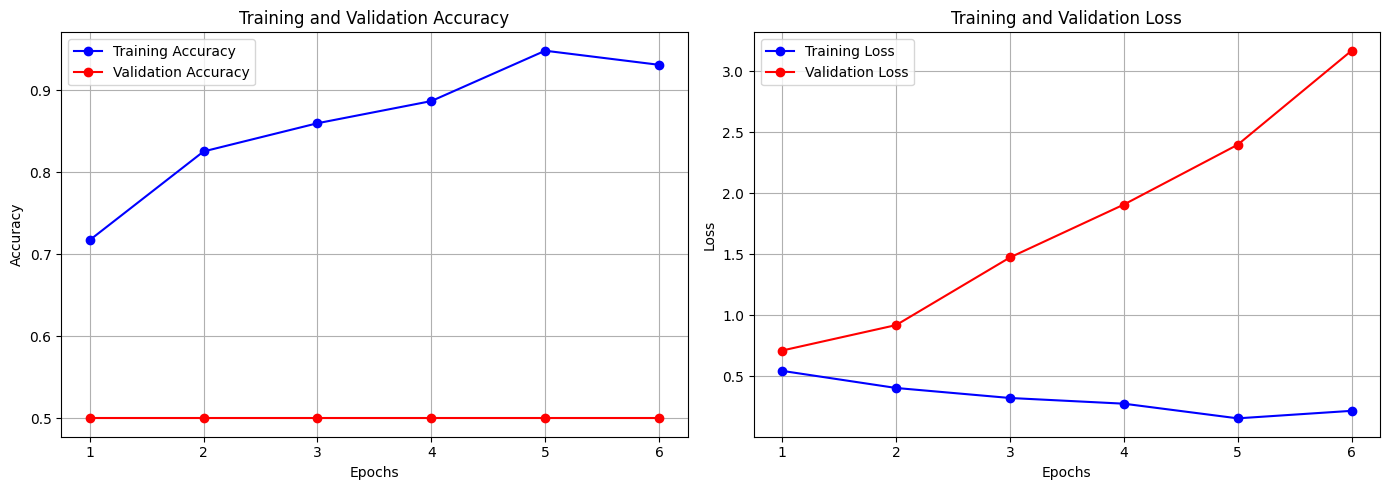

13/13 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step

--- Classification Report on Validation Set ---

              precision    recall  f1-score   support

        live       0.50      1.00      0.67       200
       spoof       0.00      0.00      0.00       200

    accuracy                           0.50       400
   macro avg       0.25      0.50      0.33       400
weighted avg       0.25      0.50      0.33       400


--- Confusion Matrix ---

[[200   0]
 [200   0]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# -------------------------------
# 1. Plot Training History
# -------------------------------
def plot_training_history(history):
    """
    Plots training & validation accuracy and loss side by side.
    """
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14,5))

    # Accuracy plot
    plt.subplot(1,2,1)
    plt.plot(epochs, acc, 'b-o', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r-o', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss plot
    plt.subplot(1,2,2)
    plt.plot(epochs, loss, 'b-o', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-o', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Call the plotting function
plot_training_history(history)

# -------------------------------
# 2. Classification Report
# -------------------------------
# Generate predictions on the validation set
validation_generator.reset()  # make sure generator starts from beginning
y_true = validation_generator.classes  # true labels
y_pred_prob = liveness_model.predict(validation_generator, steps=len(validation_generator), verbose=1)
y_pred = (y_pred_prob > 0.5).astype(int).reshape(-1)  # binary threshold at 0.5

print("\n--- Classification Report on Validation Set ---\n")
print(classification_report(y_true, y_pred, target_names=list(validation_generator.class_indices.keys())))

# Optional: Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("\n--- Confusion Matrix ---\n")
print(cm)



--- Generating Predictions on Sample Test Images ---


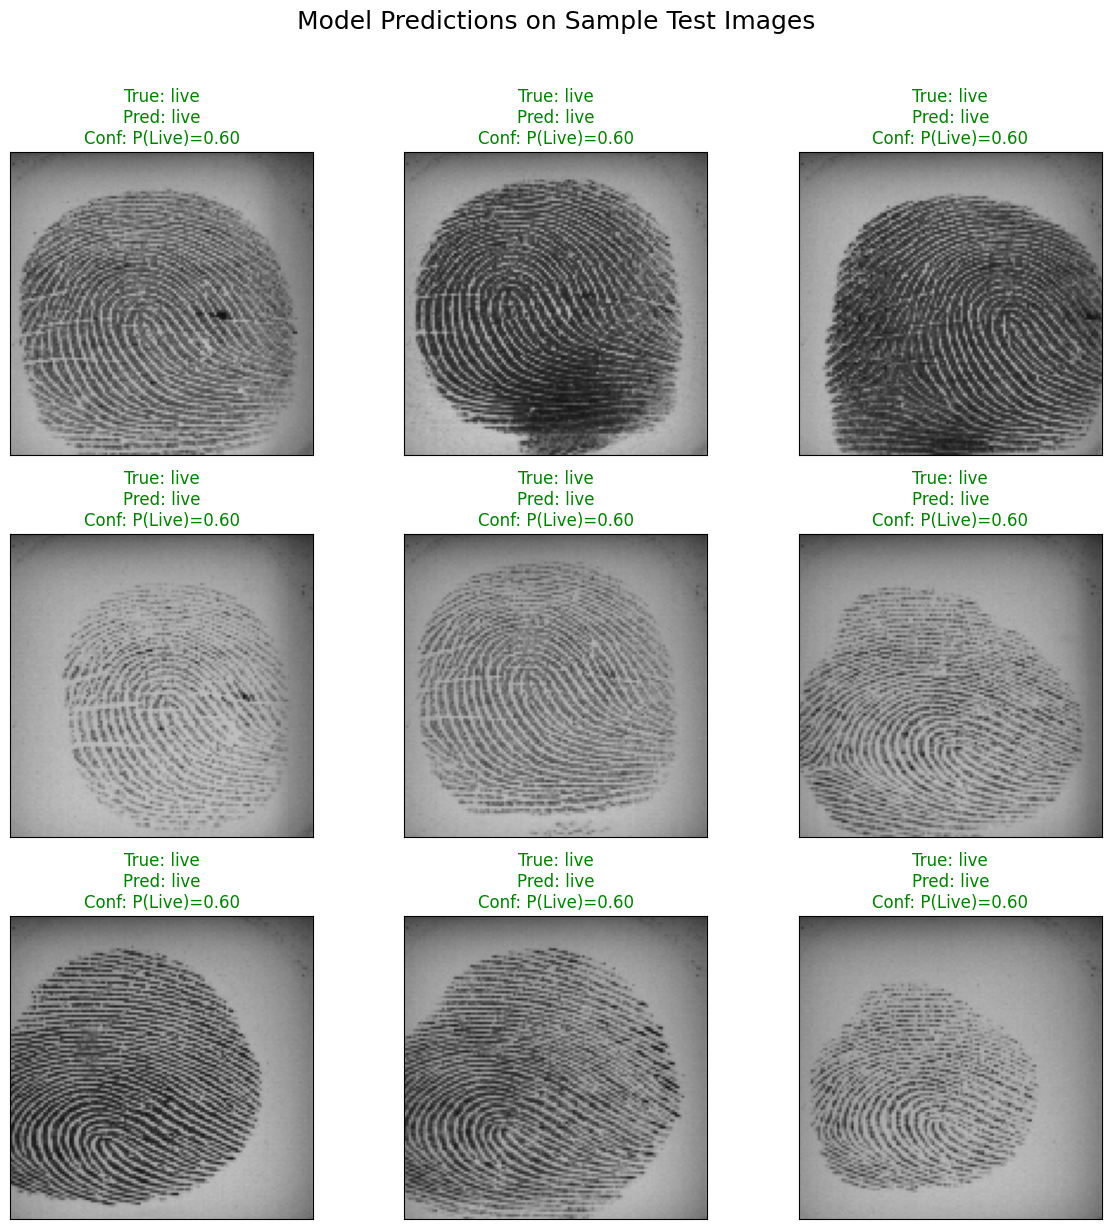


Sample image predictions displayed successfully.


In [ ]:
 #7. MODEL PREDICTION ON SAMPLE IMAGES
# ----------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt

# --- Setup Check (Assuming liveness_model and validation_generator are available) ---
# We use the defined CLASS_NAMES and access the initialized model and generator.
CLASS_NAMES = ['live', 'spoof']

print("\n" + "="*50)
print("--- Generating Predictions on Sample Test Images ---")
print("="*50)

# Get the first batch of test data from the generator
# This assumes the validation_generator variable is accessible and initialized.
try:
    X_test, y_true = validation_generator[0]
except NameError:
    print("ERROR: The 'validation_generator' or 'liveness_model' variables were not found. Ensure the setup and training sections have been executed.")
    # Exit script gracefully if dependencies are missing
    exit()

# --- Generate Predictions ---
# Make predictions on the batch
predictions_raw = liveness_model.predict(X_test, verbose=0)

# Convert raw probabilities (sigmoid output) to class labels (0 or 1)
# Prediction is 'spoof' (1) if probability is >= 0.5, 'live' (0) otherwise.
y_pred = (predictions_raw >= 0.5).astype(int)

# --- Visualization Setup ---

# Determine how many images to display (e.g., 9 images in a 3x3 grid)
N_IMAGES = min(9, len(X_test))

# Setup figure size
plt.figure(figsize=(12, 12))
plt.suptitle('Model Predictions on Sample Test Images', fontsize=18, y=1.02)


for i in range(N_IMAGES):
    # Select the i-th image, true label, and prediction
    img = X_test[i]
    true_label_index = int(y_true[i])
    predicted_label_index = y_pred[i][0] # y_pred is shape (N, 1)
    confidence_score_spoof = predictions_raw[i][0] # P(spoof)

    # Convert indices to names
    true_label_name = CLASS_NAMES[true_label_index]
    predicted_label_name = CLASS_NAMES[predicted_label_index]

    # Format confidence score display based on the predicted class
    if predicted_label_index == 1: # Predicted Spoof
        conf = confidence_score_spoof
        conf_label = f"P(Spoof)={conf:.2f}"
    else: # Predicted Live
        conf = 1.0 - confidence_score_spoof
        conf_label = f"P(Live)={conf:.2f}"

    # Set color for the prediction title: green for correct, red for incorrect
    is_correct = (true_label_index == predicted_label_index)
    color = 'green' if is_correct else 'red'

    # Create subplot
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.xticks([]) # Hide x-axis ticks
    plt.yticks([]) # Hide y-axis ticks

    # Set title with prediction details
    title = (
        f"True: {true_label_name}\n"
        f"Pred: {predicted_label_name}\n"
        f"Conf: {conf_label}"
    )
    plt.title(title, color=color, fontsize=12)


# Adjust layout to prevent image and title overlap
plt.tight_layout(rect=[0, 0, 1, 1.0])
plt.show()

print("\nSample image predictions displayed successfully.")
